In [1]:
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Conv1D, Flatten, Attention, MaxPooling1D, GRU, Input, MultiHeadAttention, Concatenate, BatchNormalization, Add, LayerNormalization, ConvLSTM2D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from keras_self_attention import SeqSelfAttention


C:\Users\User\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

dataFrame = pd.read_csv('data_full_updated.csv')
dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
dataFrame.set_index('Date', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
numeric_columns = ['Water_Level', 'Height_cm', 'Precipitation_mm', 'Avg_Temp']
dataFrame[numeric_columns] = scaler.fit_transform(dataFrame[numeric_columns])


def split_data(data, train_ratio=0.85):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


train_data, test_data = split_data(dataFrame)

print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))



Training set size: 6830
Testing set size: 1206


In [3]:
print(test_data)

            Water_Level  Height_cm  Precipitation_mm  Avg_Temp
Date                                                          
2018-09-13     0.027273   0.000000          0.052844  0.723684
2018-09-14     0.023636   0.000000          0.047432  0.802632
2018-09-15     0.023636   0.000000          0.042020  0.763158
2018-09-16     0.023636   0.000000          0.036609  0.763158
2018-09-17     0.023636   0.000000          0.031197  0.750000
...                 ...        ...               ...       ...
2021-12-27     0.023636   0.166667          0.193548  0.394737
2021-12-28     0.023636   0.216667          0.146859  0.250000
2021-12-29     0.014545   0.216667          0.100170  0.144737
2021-12-30     0.014545   0.216667          0.053480  0.210526
2021-12-31     0.016364   0.233333          0.006791  0.355263

[1206 rows x 4 columns]


In [4]:
# Проверить доступные устройства
print("Available devices:", tf.config.list_physical_devices())

# Проверить устройство для текущих операций
@tf.function
def test_device():
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
        c = tf.matmul(a, b)
        return c

print("Matrix multiplication result:", test_device())


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [5]:
def add_noise(data, noise_level=0.007):
    noise = np.random.uniform(-noise_level, noise_level, size=data.shape)
    return data + noise

def create_input_output_pairs(data, input_size, output_size):
    X = []
    y = []
    for i in range(len(data) - input_size - output_size + 1):
        temp_x = data.iloc[i:i+input_size].values
        temp_y = data.iloc[i+input_size:i+input_size+output_size]['Water_Level'].values
        temp_x1 = data.iloc[i-input_size:i+input_size-input_size].values
        temp_y1 = data.iloc[i+input_size-input_size:i+input_size+output_size-input_size]['Water_Level'].values
        if max(temp_y) - min(temp_y) > 0.1:
            for z in range(30):
                noisy_x1 = add_noise(temp_x1, noise_level=0.002)
                noisy_y1 = add_noise(temp_y1, noise_level=0.002)
                X.append(noisy_x1)
                y.append(noisy_y1)
            for z in range(30): 
                noisy_x = add_noise(temp_x, noise_level=0.002)
                noisy_y = add_noise(temp_y, noise_level=0.002) 
                X.append(noisy_x)
                y.append(noisy_y)
        X.append(data.iloc[i:i+input_size].values)
        y.append(data.iloc[i+input_size:i+input_size+output_size]['Water_Level'].values)
    X = np.array(X)
    y = np.array(y)
    return X, y
def create_input_output_pairs_test(data, input_size, output_size):
    X = []
    y = []
    for i in range(len(data) - input_size - output_size + 1):
        X.append(data.iloc[i:i+input_size].values)
        y.append(data.iloc[i+input_size:i+input_size+output_size]['Water_Level'].values)
    X = np.array(X)
    y = np.array(y)
    return X, y

input_size = 15
output_size = 10

train_X, train_y = create_input_output_pairs(train_data, input_size, output_size)
test_X, test_y = create_input_output_pairs_test(test_data, input_size, output_size)

print("Training set shape:", train_X.shape, train_y.shape)
print("Testing set shape:", test_X.shape, test_y.shape)

Training set shape: (29846, 15, 4) (29846, 10)
Testing set shape: (1182, 15, 4) (1182, 10)


In [6]:
print(test_X)



[[[0.02727273 0.         0.0528438  0.72368421]
  [0.02363636 0.         0.04743209 0.80263158]
  [0.02363636 0.         0.04202037 0.76315789]
  ...
  [0.02363636 0.         0.09653165 0.73684211]
  [0.02363636 0.         0.11447975 0.72368421]
  [0.02       0.         0.13242784 0.65789474]]

 [[0.02363636 0.         0.04743209 0.80263158]
  [0.02363636 0.         0.04202037 0.76315789]
  [0.02363636 0.         0.03660866 0.76315789]
  ...
  [0.02363636 0.         0.11447975 0.72368421]
  [0.02       0.         0.13242784 0.65789474]
  [0.01818182 0.         0.12754669 0.60526316]]

 [[0.02363636 0.         0.04202037 0.76315789]
  [0.02363636 0.         0.03660866 0.76315789]
  [0.02363636 0.         0.03119694 0.75      ]
  ...
  [0.02       0.         0.13242784 0.65789474]
  [0.01818182 0.         0.12754669 0.60526316]
  [0.01636364 0.         0.12266553 0.63157895]]

 ...

 [[0.02727273 0.         0.00509338 0.42105263]
  [0.02545455 0.         0.00509338 0.43421053]
  [0.02545

In [7]:
class ReduceMeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)

def create_gru_attention_model(input_shape, output_size):
    inputs = Input(shape=input_shape)
    
    gru_out = GRU(50, return_sequences=True)(inputs)
    gru_out = Dropout(0.2)(gru_out)
    gru_out = GRU(50, return_sequences=True)(gru_out)
    gru_out = Dropout(0.2)(gru_out)
    

    attention_out = MultiHeadAttention(num_heads=2, key_dim=50)(gru_out, gru_out)
    attention_out = LayerNormalization()(attention_out)
    concat = ReduceMeanLayer()(attention_out)
    

    dense_out = Dense(50, activation='relu')(concat)
    dense_out = Dropout(0.2)(dense_out)
    outputs = Dense(output_size)(dense_out)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mape',
        metrics=['mape']
    )
    
    return model

input_shape = (input_size, len(numeric_columns))
model = create_gru_attention_model(input_shape, output_size)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(
    optimizer='adam',
    loss='mape',
    metrics=['mape', 'mae', 'mse']
)

history = model.fit(
    train_X, train_y,
    epochs=120,
    batch_size=32,
    callbacks=[lr_schedule]
)

Epoch 1/120
933/933 [==============================] - 19s 14ms/step - loss: 269.0216 - mape: 269.0216 - mae: 0.3225 - mse: 0.1651 - lr: 1.0000e-08
Epoch 2/120
933/933 [==============================] - 13s 14ms/step - loss: 265.0428 - mape: 265.0428 - mae: 0.3191 - mse: 0.1621 - lr: 1.1220e-08
Epoch 3/120
933/933 [==============================] - 13s 14ms/step - loss: 261.6211 - mape: 261.6211 - mae: 0.3158 - mse: 0.1591 - lr: 1.2589e-08
Epoch 4/120
933/933 [==============================] - 13s 14ms/step - loss: 257.8641 - mape: 257.8641 - mae: 0.3123 - mse: 0.1560 - lr: 1.4125e-08
Epoch 5/120
933/933 [==============================] - 13s 14ms/step - loss: 252.5919 - mape: 252.5919 - mae: 0.3079 - mse: 0.1522 - lr: 1.5849e-08
Epoch 6/120
933/933 [==============================] - 13s 14ms/step - loss: 247.9917 - mape: 247.9917 - mae: 0.3035 - mse: 0.1482 - lr: 1.7783e-08
Epoch 7/120
933/933 [==============================] - 13s 14ms/step - loss: 242.6528 - mape: 242.6528 - mae: 0.

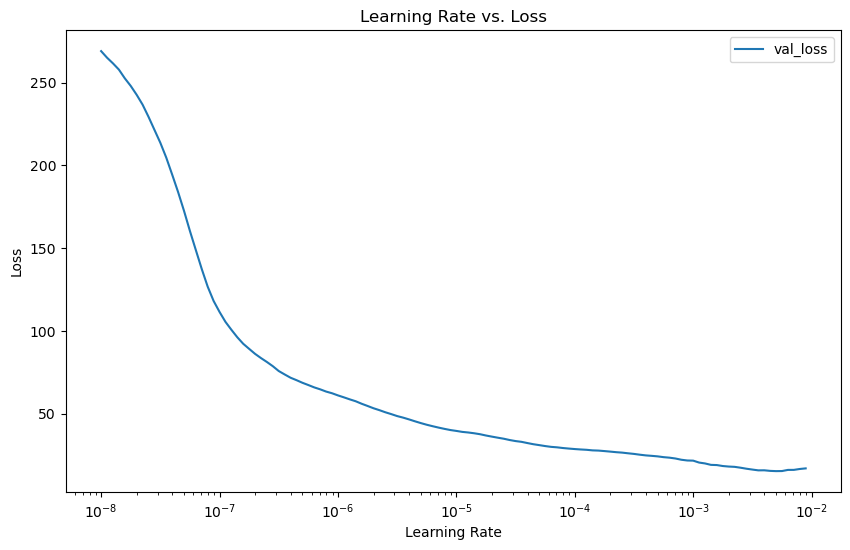

In [9]:

lrs = 1e-8 * (10 ** (np.arange(120) / 20))
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["loss"], label='val_loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Loss')
plt.legend()
plt.show()


In [10]:

min_loss_idx = np.argmin(history.history["loss"])
best_lr = lrs[min_loss_idx]

print(f"Best learning rate found: {best_lr}")

model.compile(loss='mape', optimizer=Adam(learning_rate=best_lr), metrics=['mape'])
early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_X, train_y,
    epochs=120,
    batch_size=32,
    validation_data=(test_X, test_y),
    callbacks=[early_stopping]
)


Best learning rate found: 0.005011872336272725
Epoch 1/120
933/933 [==============================] - 15s 14ms/step - loss: 15.0166 - mape: 15.0166 - val_loss: 96285.6953 - val_mape: 96285.6953
Epoch 2/120
933/933 [==============================] - 11s 12ms/step - loss: 14.3038 - mape: 14.3038 - val_loss: 87052.2656 - val_mape: 87052.2656
Epoch 3/120
933/933 [==============================] - 12s 13ms/step - loss: 13.9346 - mape: 13.9346 - val_loss: 104546.3516 - val_mape: 104546.3516
Epoch 4/120
933/933 [==============================] - 12s 13ms/step - loss: 13.8298 - mape: 13.8298 - val_loss: 91931.6172 - val_mape: 91931.6172
Epoch 5/120
933/933 [==============================] - 12s 13ms/step - loss: 14.7747 - mape: 14.7747 - val_loss: 96665.8672 - val_mape: 96665.8672
Epoch 6/120
933/933 [==============================] - 12s 13ms/step - loss: 13.6524 - mape: 13.6524 - val_loss: 90105.9297 - val_mape: 90105.9297
Epoch 7/120
933/933 [==============================] - 12s 13ms/step 

1/1 [==============================] - 0s 15ms/step


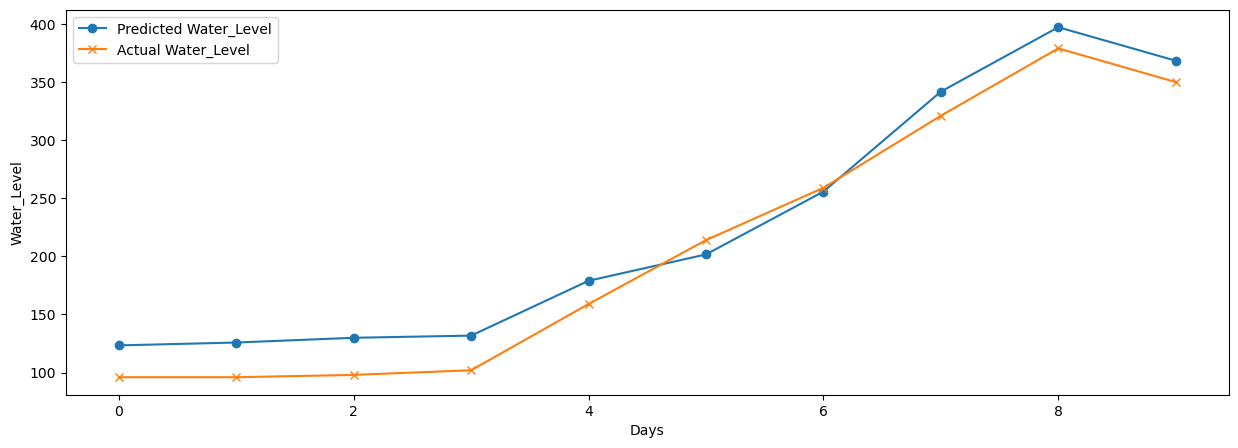

In [90]:
dfdf = pd.read_csv('data_full_updated.csv')

water_level_scaler = MinMaxScaler(feature_range=(0, 1))

dfdf['Water_Level'] = dfdf[['Water_Level']]
water_level_scaler.fit(dfdf[['Water_Level']])

dfdf['Water_Level'] = water_level_scaler.transform(dfdf[['Water_Level']])

day =  918

initial_input = test_X[day]


predicted_values = model.predict(initial_input[np.newaxis, :, :])


predicted_values_reshaped = predicted_values.reshape(-1, 1)

predicted_values_denormalized = water_level_scaler.inverse_transform(predicted_values_reshaped)

actual_values = test_y[day]
actual_values_reshaped = actual_values.reshape(-1, 1)
actual_values_denormalized = water_level_scaler.inverse_transform(actual_values_reshaped)

plt.figure(figsize=(15, 5))
plt.plot(predicted_values_denormalized, label='Predicted Water_Level', marker='o')
plt.plot(actual_values_denormalized, label='Actual Water_Level', marker='x')

plt.xlabel('Days')
plt.ylabel('Water_Level')
plt.legend()
plt.show()
